# Time Series in PM

### Журнал событий относится к процессу управления заявками службы поддержки итальянской компании-разработчика программного обеспечения.

**Детали журнала:** 
- 21348 событий
- 4580 случаев
- 14 видов активности

**Ниже приведен список атрибутов со средними значениями:**

- **Case ID:** идентификатор случая
- **Activity:** название активности
- **Resource:** ресурс, который выполнил действие
- **Complete Timestamp:** временная метка события. Формат: YYYY/MM/DD hh:mm:ss.sss
- **Variant:** вариант случая
- **Variant index:** вариант случая в числовом формате
- **Seriousness:** уровень серьезности тикета
- **Customer:** имя клиента
- **Product:** название продукта
- **Responsible_section:** название ответственного отдела
- **Seriousness_2:** подуровень серьезности
- **Service_level:** уровень сервиса
- **Service_type:** тип сервиса
- **Support_section:** название отдела поддержки
- **Workgroup:** название рабочей группы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pm4py
import numpy as np
from datetime import datetime
from collections import defaultdict
from sklearn.metrics import (mean_squared_error, precision_score, recall_score, 
                             mean_absolute_error, mean_absolute_percentage_error)
from scipy.spatial import distance
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW
from arch.univariate import arch_model as ARCH
from pm4py.objects.log.importer.xes import importer as xes_importer
from math import sqrt
import networkx as nx
import warnings
import json
import os
from import_data import read_data_equisize, read_data_equitemp, determine_cutoff_point, ActivityPair
from forecasting import ARf, ARIMAf, SESf, HWf, NAVf, ESf, GARCHf
from operations import calculate_entropic_relevance
from pm4py.objects.log.importer.xes import importer as xes_importer
from math import sqrt
from sklearn.metrics import mean_squared_error, precision_score, recall_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.spatial import distance
from import_data import read_data_equisize, read_data_equitemp, determine_cutoff_point, ActivityPair
from forecasting import ARf, ARIMAf, SESf, HWf, NAVf, ESf, GARCHf
warnings.filterwarnings("ignore")
from datetime import datetime
from collections import defaultdict

warnings.filterwarnings("ignore")

## EDA лога

In [2]:
file_path = '/Users/artemmm/Downloads/pmf/pmf/artem/italian.csv'
log_data = pd.read_csv(file_path)
removal_stats = {}

#дубликаты
initial_rows = log_data.shape[0]
log_data = log_data.drop_duplicates()
removal_stats['duplicates_removed'] = initial_rows - log_data.shape[0]

#пропуски
rows_before_na_removal = log_data.shape[0]
log_data = log_data.dropna(subset=['concept:name', 'time:timestamp', 'case:concept:name'])
removal_stats['missing_values_removed'] = rows_before_na_removal - log_data.shape[0]

#преобразование временных меток
log_data['time:timestamp'] = pd.to_datetime(log_data['time:timestamp'], errors='coerce', utc=True)

#временные метки
rows_before_invalid_timestamps = log_data.shape[0]
log_data = log_data.dropna(subset=['time:timestamp'])
removal_stats['invalid_timestamps_removed'] = rows_before_invalid_timestamps - log_data.shape[0]

#удаление столбцов
columns_to_keep = [
    'concept:name', 'lifecycle:transition', 'org:resource', 'time:timestamp',
    'Activity', 'Resource', 'case:concept:name', 'case:variant',
    'case:variant-index'
]
log_data = log_data[columns_to_keep]

#типы данных
rows_before_variant_index_check = log_data.shape[0]
log_data['case:variant-index'] = pd.to_numeric(log_data['case:variant-index'], errors='coerce')
log_data = log_data.dropna(subset=['case:variant-index'])
removal_stats['invalid_variant_indices_removed'] = rows_before_variant_index_check - log_data.shape[0]

log_data = log_data.sort_values(by=['case:concept:name', 'time:timestamp'])

for reason, count in removal_stats.items():
    print(f"{reason}: {count} строк найдено")

duplicates_removed: 127 строк найдено
missing_values_removed: 0 строк найдено
invalid_timestamps_removed: 0 строк найдено
invalid_variant_indices_removed: 0 строк найдено


# Преобразование лога в временной ряд

### 1. Выбор количества интервалов.

Нужно подобрать оптимальное кол-во интервалов, т.к.
- Слишком мало интервалов может сгладить данные, теряя важные детали.
- Слишком много интервалов приводит к разреженным данным, что усложняет прогнозирование.

Оптимальное количество интервалов — 100, так как при этом минимизируется стандартное отклонение числа событий между интервалами (0.27 события). Это обеспечивает равномерность распределения, уменьшая разброс между интервалами.
Достаточное количество данных в каждом интервале (минимум ~305 событий).

### 2. Агрегация лога

<img src="equitemp.png" alt="Описание изображения" style="max-width: 60%; height: auto;">


In [3]:
interval_timings = ['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', 
                    '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', 
                    '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', 
                    '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', 
                    '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', 
                    '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', 
                    '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', 
                    '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', 
                    '2014-01']

In [4]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
import numpy as np
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer

def load_and_process_log(log_path, agg_type='equitemp', no_intervals=100):
    log = xes_importer.apply(log_path)
    activity_names = pm4py.get_attribute_values(log, 'concept:name')
    act_map = {value: idx for idx, value in enumerate(activity_names.keys())}
    act_map.update({'start': len(act_map), 'end': len(act_map)})  # Добавление start/end
    reverse_map = {idx: value for value, idx in act_map.items()}
    no_act = len(act_map)
    apairs = [
        (event['concept:name'], trace[i + 1]['concept:name'], trace[i + 1]['time:timestamp'])
        for trace in log for i, event in enumerate(trace[:-1])
    ]
    apairs.sort(key=lambda x: x[2])
    
    intervals, dfg_time_matrix = [], np.zeros((no_intervals, no_act, no_act), dtype=int)
    transitions_table = []  # Список для формирования таблицы

    if agg_type == 'monthly':
        month_buckets = defaultdict(list)
        for act1, act2, timestamp in apairs:
            month = datetime.fromisoformat(str(timestamp)).strftime("%Y-%m")
            month_buckets[month].append((act1, act2, timestamp))
        intervals = sorted(month_buckets.keys())
        for i, month in enumerate(intervals):
            start_time = datetime.strptime(month + "-01", "%Y-%m-%d")
            end_time = (start_time + pd.offsets.MonthEnd()).to_pydatetime()
            for act1, act2, timestamp in month_buckets[month]:
                dfg_time_matrix[i, act_map[act1], act_map[act2]] += 1
                # Добавляем данные в таблицу
                transitions_table.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'start_stage': act1,
                    'end_stage': act2,
                    'transitions_count': dfg_time_matrix[i, act_map[act1], act_map[act2]]
                })
    else:
        timestamps = [x[2] for x in apairs]
        if agg_type == 'equitemp':
            interval_length = (max(timestamps) - min(timestamps)) / no_intervals
            intervals = [(min(timestamps) + i * interval_length, min(timestamps) + (i + 1) * interval_length) for i in range(no_intervals)]
        else:
            interval_size = len(apairs) // no_intervals
            intervals = [(apairs[i * interval_size][2], apairs[min((i + 1) * interval_size, len(apairs) - 1)][2]) for i in range(no_intervals)]
        for i, (start, end) in enumerate(intervals):
            for act1, act2, timestamp in apairs:
                if start <= timestamp < end:
                    dfg_time_matrix[i, act_map[act1], act_map[act2]] += 1
                    # Добавляем данные в таблицу
                    transitions_table.append({
                        'start_time': start,
                        'end_time': end,
                        'start_stage': act1,
                        'end_stage': act2,
                        'transitions_count': dfg_time_matrix[i, act_map[act1], act_map[act2]]
                    })

    # Преобразуем список в DataFrame
    transitions_df = pd.DataFrame(transitions_table)
    
    return dfg_time_matrix, intervals, act_map, reverse_map, transitions_df

log_path = 'italian.xes'
dfg_matrix, intervals, act_map, reverse_map, transitions_df = load_and_process_log(log_path, agg_type='monthly')

print("DFG Time Series Matrix Shape:", dfg_matrix.shape)
print("First Interval (Month):", intervals[0])
print("Activity Map:", act_map)
print("Transitions DataFrame:")
# transitions_df.to_csv('transitions.csv', index = False)


parsing log, completed traces :: 100%|████| 4580/4580 [00:01<00:00, 3466.56it/s]


DFG Time Series Matrix Shape: (100, 18, 18)
First Interval (Month): 2010-01
Activity Map: {'Start': 0, 'Assign seriousness': 1, 'Take in charge ticket': 2, 'Resolve ticket': 3, 'Closed': 4, 'End': 5, 'Insert ticket': 6, 'Wait': 7, 'Create SW anomaly': 8, 'Require upgrade': 9, 'VERIFIED': 10, 'DUPLICATE': 11, 'Resolve SW anomaly': 12, 'Schedule intervention': 13, 'RESOLVED': 14, 'INVALID': 15, 'start': 16, 'end': 16}
Transitions DataFrame:


In [5]:
dfg_matrix

array([[[ 0, 22,  0, ...,  0,  0,  0],
        [ 0,  6, 14, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0, 54,  0, ...,  0,  0,  0],
        [ 0,  9, 50, ...,  0,  0,  0],
        [ 0,  0,  1, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0, 64,  1, ...,  0,  0,  0],
        [ 0, 14, 75, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0

## EDA временного ряда

**Что такое станционарность временного ряда?**
- Стационарность временного ряда — это свойство ряда, при котором его основные статистические характеристики (например, среднее, дисперсия) не изменяются со временем. Стационарный ряд считается более предсказуемым и подходящим для большинства методов временного анализа.

**Проверка станционарности**

Будем использовать тест Дики-Фуллера - adfuller в statsmodels.

- Нулевая гипотеза H0 - временной ряд нестационарен.
- Альтернативная гипотеза H1 - временной ряд стационарен.

Утверждать что ряд станционарен/не станционарен будем на основе критического значения. Оно у нас -2.9 (на уровне значимости 5% (число возвращается библиотекой statsmodels).

p-value показывает вероятность ошибочного отвержения нулевой гипотезы, если она верна.
* Если p-value < 0.05, вероятность того, что ряд нестационарен, мала.
* Если p-value ≥ 0.05, данные не дают оснований отвергнуть нулевую гипотезу.

Следовательно, те значения ADF, которые < -2.9 = станционарные (отвергается нулевая гипотеза в пользу альтернативной)

In [6]:
stat_znachimost = 0.5
def check_stationarity_full_series(dfg_matrix, act_map):
    results = []
    for act1, idx1 in act_map.items():
        for act2, idx2 in act_map.items():
            series = np.sum(dfg_matrix[:, idx1, idx2])
            if series > 0:
                full_series = dfg_matrix[:, idx1, idx2]
                result = adfuller(full_series)
                results.append({
                    "От": act1,
                    "К": act2,
                    "ADF показатель": result[0],
                    "p-value": result[1],
                    "Станционарность": result[1] < stat_znachimost
                })
    return pd.DataFrame(results)
stationarity_results_full = check_stationarity_full_series(dfg_matrix, act_map)

print(stationarity_results_full.to_string(index=False))

                   От                     К  ADF показатель      p-value  Станционарность
                Start    Assign seriousness       -0.915510 7.828220e-01            False
                Start Take in charge ticket       -5.084171 1.508367e-05             True
                Start        Resolve ticket       -3.981060 1.513000e-03             True
                Start         Insert ticket       -4.652081 1.034386e-04             True
                Start                  Wait       -9.949874 2.531378e-17             True
                Start     Create SW anomaly       -9.949874 2.531378e-17             True
   Assign seriousness    Assign seriousness       -1.577424 4.949236e-01             True
   Assign seriousness Take in charge ticket       -0.767771 8.284063e-01            False
   Assign seriousness        Resolve ticket       -2.823146 5.504281e-02             True
   Assign seriousness                  Wait       -1.373301 5.950070e-01            False
   Assign 

Т.к. большинство временных рядов имеют низкий показатель p-value, это подтверждает их приближение к станционарному ряду.

Далее следует проверка на сезонность и тренд.

seasonal_decompose - декомпозиция временного ряда, которая разбивает его на три основные компоненты:

* Тренд (trend): Долгосрочное поведение данных (например, общий рост или спад).
* Сезонность (seasonal): Регулярно повторяющиеся циклы, связанные с временными периодами (например, сезонные колебания продаж).
* Остатки (residuals): Нерегулярная часть, которую нельзя объяснить трендом и сезонностью.

In [7]:
#import numpy as np
#import pandas as pd
#from statsmodels.tsa.seasonal import seasonal_decompose
#def check_trends_and_seasonality(dfg_matrix, act_map, freq=12):
#    results = []
#    for act1, idx1 in act_map.items():
#        for act2, idx2 in act_map.items():
#            series = np.sum(dfg_matrix[:, idx1, idx2])
#            if series > 0:
#                full_series = dfg_matrix[:, idx1, idx2]
#                decomposition = seasonal_decompose(full_series, period=freq, model='additive')                
#                results.append({
#                    "От": act1,
#                    "К": act2,
#                    "Наличие тренда": np.any(np.abs(decomposition.trend) > 1e-2) if decomposition.trend is not None else False,
#                    "Наличие сезонности": np.any(np.abs(decomposition.seasonal) > 1e-2) if decomposition.seasonal is not None else False
#                })
#    return pd.DataFrame(results)
#stationarity_and_trends_results = check_trends_and_seasonality(dfg_matrix, act_map)
#print(stationarity_and_trends_results.to_string(index=False))

**Вывод:**
* Есть тренд на снижение
* Присутствуют циклические колебания, что указывает на наличие сезонности

## Моделирование и предсказание временного ряда

In [8]:
horizon = 25  #на какое кол-во интервалов прогноз

### ARIMA
- AR - AutoRegression
- I - Integrated
- MA - Moving Average (бегущее среднее)

AutoRegression - использует прошлые значения для предсказания будущих. Смысл в том, чтобы найти коэффициенты, которые показывают, как сильно предыдущие значения влияют на будущие.

Integrated - это способ сделать ряд более станционарным. "Интеграция вычисляет разности между точками, пока ряд не станет более стабильным."

Moving Average - ошибки прошлого влияют на результат будущих предсказаний. "Если вчера ошибка в прогнозе температуры составляла 2 градуса, то в сегодняшнем прогнозе мы это учтём".

### AutoRegression

Модель ищет закономерности в предыдущих предсказаниях, и предсказывает на их основе.

У модели есть глубина, (параметр d), т.е. несколько далеко назад будет смотреть модель (2 точки в нашем случае).

### SimpleExponentialSmoothing
Простое экспоненциальное сглаживание - усредняет уже имеющиеся наблюдения.

Когда используют:
* Нет тренда
* Нет сезонности

### Holt-Winters
"Тройное экспоненциальное сглаживание" - расширенная версия экс. сглаживания, так как он работает на его основе, но с учетом тренда и сезонности.

Когда используют:
* С трендом
* С сезонностью

### Native

Среднее значение ряда как прогноз

### Garch

Эта модель используется для анализа и прогнозирования изменчивости (волатильности) временных рядов. Она помогает учитывать, что волатильность может изменяться во времени и быть связанной с предыдущими ошибками и волатильностью.

GARCH сочетает AR (авторегрессию) и MA (скользящее среднее) для моделирования дисперсии (волатильности).

* Предыдущие ошибки (MA) и значения дисперсии (AR) влияют на текущую волатильность.
* Прогнозы строятся с учётом изменчивости во времени.

In [10]:
import pm4py
import json
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error, precision_score, recall_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.spatial import distance

from import_data import read_data_equisize, read_data_equitemp, determine_cutoff_point, ActivityPair
from forecasting import ARf, ARIMAf, SESf, HWf, NAVf, ESf, GARCHf
from operations import calculate_entropic_relevance

import networkx as nx
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from collections import defaultdict

def read_data_by_months(sorted_aps, act_map, log, dataset):
    from collections import defaultdict

    # Инициализация структуры для хранения данных
    monthly_data = defaultdict(list)
    
    # Группировка событий по месяцам
    for ap in sorted_aps:
        # Извлекаем метку времени и преобразуем в формат "Год-Месяц"
        timestamp = ap.timestamp
        if not isinstance(timestamp, datetime):
            timestamp = datetime.fromisoformat(str(timestamp))
        month = timestamp.strftime('%Y-%m')
        
        # Добавляем событие в соответствующий месяц
        monthly_data[month].append((act_map[ap.a1], act_map[ap.a2]))

    # Преобразование данных в матрицу
    months = sorted(monthly_data.keys())  # Сортировка месяцев
    dfg_matrix = np.zeros((len(months), len(act_map), len(act_map)), dtype=int)

    for i, month in enumerate(months):
        for act1, act2 in monthly_data[month]:
            dfg_matrix[i, act1, act2] += 1
    
    # Возврат матрицы и списка месяцев
    return dfg_matrix, months


############
# Parameters

dataset = 'italian'
agg_type = 'monthly' # возможен параметр 'equitemp'
no_pairs = 0
horizon = 25
no_intervals = 75
no_folds = 10
no_intervals_all = 100

# Parameters
############


variant = xes_importer.Variants.ITERPARSE
paras = {variant.value.Parameters.MAX_TRACES: 1000000000}
log = xes_importer.apply(dataset + '.xes', parameters=paras)

# read and encode data
activity_names = pm4py.get_attribute_values(log, 'concept:name')
no_act = len(activity_names)
act_map = {}
reverse_map = {}
for a, value in enumerate(activity_names.keys()):
    act_map[value] = a
    reverse_map[a] = value

# add start and end points for DFGs
act_map['start'] = no_act
act_map['end'] = no_act + 1
reverse_map[no_act] = 'start'
reverse_map[no_act+1] = 'end'
no_act += 2
print('Activity encoding:', act_map)

# store all directly-follows occurrences as activity pairs
apairs = []
for t, trace in enumerate(log):
    for e, event in enumerate(trace):
        if e == len(trace) - 1:
            continue
        ap = ActivityPair(event['concept:name'], trace[e+1]['concept:name'], trace[e+1]['time:timestamp'], event, trace[e+1], t)
        apairs.append(ap)

sorted_aps = sorted(apairs)
print('#DFs:', len(sorted_aps))

interval_width = int(len(sorted_aps) / no_intervals_all)

def calculate_mean_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    # Ensure inputs are numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Avoid division by zero issues
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_errors = np.abs((y_true - y_pred) / y_true)
        percentage_errors = np.where(np.isfinite(percentage_errors), percentage_errors, 0)  # Replace NaN/inf with 0

    # Calculate the mean absolute percentage error
    mape = np.mean(percentage_errors) * 100
    return mape

# transform the separate DFs into a matrix dfg_time_matrix_org of
# interval x activities x activities
# transform the separate DFs into a matrix dfg_time_matrix_org of
# interval x activities x activities
if os.path.isfile(f'dfg___time_matrix_{dataset}_{agg_type}.npy'):
    with open(f'dfg_time_matrix_{dataset}_{agg_type}.npy', 'rb') as f:
        dfg_time_matrix_org = np.load(f)
    print('Read matrix:', dfg_time_matrix_org.shape)
else:
    print('Creating DFG matrix')
    if agg_type == 'monthly':
        dfg_time_matrix_org, interval_timings = read_data_by_months(sorted_aps, act_map, log, dataset)
    elif agg_type == 'equitemp':
        dfg_time_matrix_org, interval_timings = read_data_equitemp(
    no_intervals_all,  # no_intervals
    interval_width,    # interval_width
    sorted_aps,        # sorted_aps
    act_map,           # act_map
    log,               # log
    dataset            # dataset
)


    with open(f'dfg_time_matrix_{dataset}_{agg_type}.npy', 'wb') as f:
        np.save(f, dfg_time_matrix_org)

# determine cutoff in case only the most frequent subset of DF pairs needs to be retained
if no_pairs == 0:
    cutoff = 0
else:
    cutoff = determine_cutoff_point(act_map, dfg_time_matrix_org, no_pairs)

# reduce matrix according to parameter settings
dfg_time_matrix = dfg_time_matrix_org[:no_intervals, ::, ::]

techniques = ['nav', 'ar1', 'ar2', 'ar4', 'arima211', 'arima212', 'hw', 'garch']

dfg_result_matrix = {}
dfg_actual_matrix = np.zeros([no_act, no_act, no_folds, horizon], dtype=int)

for technique in techniques:
    dfg_result_matrix[technique] = np.zeros([no_act, no_act, no_folds, horizon], dtype=float)

chosen_pairs = set()
# forecast DFs of all activity pairs
for act, a in act_map.items():
    for act_2, a2 in act_map.items():

        # by default only time series with at least 1 DF will be selected
        if np.sum(dfg_time_matrix[:, a, a2]) > cutoff:
            print('DFG', act, 'and', act_2)
            chosen_pairs.add((a, a2))

            # get DF
            array = dfg_time_matrix[:, a, a2]

            techniques = dict()
            techniques['nav'] = NAVf()
            # techniques['ar1'] = ARf(1)
            techniques['ar2'] = ARf(2)
            techniques['ar4'] = ARf(4)
            # techniques['arima211'] = ARIMAf(2, 1, 1)
            techniques['arima212'] = ARIMAf(2, 1, 2)
            techniques['hw'] = HWf()
            techniques['garch'] = GARCHf()

            # cross-validation is applied
            for fold in range(0, no_folds):
                # offset for cross-validation
                offset = - fold - horizon
                x = array[:offset]

                if fold == 0:
                    y = array[offset:]
                else:
                    y = array[offset:(offset + horizon)]

                # store actual
                dfg_actual_matrix[a, a2, fold] = y

                for technique, implement in techniques.items():
                    y_pred = []
                    my_x = np.copy(x)

                    try:
                        # predict horizon steps ahead
                        y_hat = implement.fit(my_x, horizon)
                        y_pred = y_hat
                        dfg_result_matrix[technique][a, a2, fold] = y_pred
                    except:
                        dfg_result_matrix[technique][a, a2, fold] = np.full((horizon, ), 100000000)
            # End results of fold
        # End of -if > cutoff
    # End of act 2
# End of act 1

# Results per horizon/fold
with open(f'results_{dataset}_nopairs_{no_pairs}_nointervals_{str(no_intervals)}_{agg_type}.csv', 'w') as technique_fold_results:
    technique_fold_results.write('intervals,technique,fold,horizon,cosine,rmse,mape,er_pred,er_actual\n')

    for technique in techniques:
        print(f'Technique {technique}')
        dfg_result_matrix_ar = dfg_result_matrix[technique]
        results_selected = np.zeros((len(chosen_pairs), no_folds, horizon))
        actual_selected = np.zeros((len(chosen_pairs), no_folds, horizon))

        for p, pair in enumerate(chosen_pairs):
            results_selected[p] = dfg_result_matrix_ar[pair[0], pair[1], ::, ::]
            actual_selected[p] = dfg_actual_matrix[pair[0], pair[1], ::, ::]

        for h in range(0, horizon):
            for fold in range(0, no_folds):
                # print(f'Fold {fold} - horizon {h}')

                #####################
                # Forecast DFG output
                nodes = []
                for act_name, act_code in act_map.items():
                    out_freq = int(np.sum(dfg_result_matrix_ar[act_code, ::, fold, h]))
                    in_freq = int(np.sum(dfg_result_matrix_ar[::, act_code, fold, h]))

                    if act_name == 'start':
                        nodes.append({'label': str(act_code), 'freq': out_freq, 'id': act_code})
                    else:
                        if in_freq > 0:
                            nodes.append({'label': str(act_code), 'freq': in_freq, 'id': act_code})

                arcs = []
                for a in range(0, len(act_map)):
                    for a2 in range(0, len(act_map)):
                        if int(dfg_result_matrix_ar[a, a2, fold, h]) > 0:
                            arcs.append({'from': a, 'to': a2, 'freq': int(dfg_result_matrix_ar[a, a2, fold, h])})

                # calculate entropic relevance
                dfg_file = {'nodes': nodes, 'arcs': arcs}
                r = json.dumps(dfg_file, indent=1)
                with open(f'temp.json', 'w') as dfg_write_file:
                    dfg_write_file.write(r)

                offset = no_intervals - horizon + h - fold
                er_technique = calculate_entropic_relevance(f'./logs/{dataset}_log_interval_{offset}-{no_intervals_all}_{agg_type}', 'temp')


                ###################
                # Actual DFG output
                nodes = []
                for act_name, act_code in act_map.items():
                    out_freq = int(np.sum(dfg_actual_matrix[act_code, ::, fold, h]))
                    in_freq = int(np.sum(dfg_actual_matrix[::, act_code, fold, h]))

                    if act_name == 'start':
                        nodes.append({'label': str(act_code), 'freq': out_freq, 'id': act_code})
                    else:
                        if in_freq > 0:
                            nodes.append({'label': str(act_code), 'freq': in_freq, 'id': act_code})

                arcs = []
                for a in range(0, len(act_map)):
                    for a2 in range(0, len(act_map)):
                        if int(dfg_actual_matrix[a, a2, fold, h]) > 0:
                            arcs.append({'from': a, 'to': a2, 'freq': int(dfg_actual_matrix[a, a2, fold, h])})

                # calculate entropic relevance
                dfg_file = {'nodes': nodes, 'arcs': arcs}
                r = json.dumps(dfg_file, indent=1)
                with open(f'temp.json', 'w') as dfg_write_file:
                    dfg_write_file.write(r)

                offset = no_intervals - horizon + h - fold
                er_actual = calculate_entropic_relevance(f'./logs/{dataset}_log_interval_{offset}-{no_intervals_all}_{agg_type}', 'temp')

                # store results
                results = np.reshape(results_selected[::, fold, h], (1, len(chosen_pairs)))
                actuals = np.reshape(actual_selected[::, fold, h], (1, len(chosen_pairs)))

                cosine = distance.cosine(results, actuals)
                rmse = sqrt(mean_squared_error(actuals, results))
                try:
                    mape = calculate_mean_percentage_error(actuals, results)
                except ValueError:
                    mape = float('inf')
                technique_fold_results.write(f'{no_intervals},{technique},{str(fold)},{str(h)},{cosine},{rmse},{mape},{er_technique},{er_actual}\n')

parsing log, completed traces :: 100%|████| 4580/4580 [00:01<00:00, 3699.23it/s]


Activity encoding: {'Start': 0, 'Assign seriousness': 1, 'Take in charge ticket': 2, 'Resolve ticket': 3, 'Closed': 4, 'End': 5, 'Insert ticket': 6, 'Wait': 7, 'Create SW anomaly': 8, 'Require upgrade': 9, 'VERIFIED': 10, 'DUPLICATE': 11, 'Resolve SW anomaly': 12, 'Schedule intervention': 13, 'RESOLVED': 14, 'INVALID': 15, 'start': 16, 'end': 17}
#DFs: 25928
Creating DFG matrix
DFG Start and Assign seriousness
DFG Start and Take in charge ticket
DFG Start and Resolve ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Start and Insert ticket
DFG Start and Wait


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Start and Create SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Assign seriousness and Assign seriousness
DFG Assign seriousness and Take in charge ticket
DFG Assign seriousness and Resolve ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Assign seriousness and Wait
DFG Assign seriousness and Create SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Assign seriousness and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Take in charge ticket and Assign seriousness
DFG Take in charge ticket and Take in charge ticket
DFG Take in charge ticket and Resolve ticket
DFG Take in charge ticket and End


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Take in charge ticket and Wait
DFG Take in charge ticket and Create SW anomaly
DFG Take in charge ticket and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Take in charge ticket and Resolve SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Take in charge ticket and Schedule intervention
DFG Resolve ticket and Assign seriousness


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve ticket and Take in charge ticket
DFG Resolve ticket and Resolve ticket
DFG Resolve ticket and Closed
DFG Resolve ticket and End
DFG Resolve ticket and Wait


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve ticket and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve ticket and RESOLVED


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Closed and Take in charge ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Closed and Closed
DFG Closed and End
DFG Closed and VERIFIED


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


DFG Insert ticket and Assign seriousness
DFG Insert ticket and Take in charge ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Insert ticket and Wait


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Wait and Assign seriousness


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Wait and Take in charge ticket
DFG Wait and Resolve ticket
DFG Wait and End


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Wait and Wait
DFG Wait and Create SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Wait and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Create SW anomaly and Take in charge ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Create SW anomaly and Resolve ticket
DFG Create SW anomaly and Create SW anomaly
DFG Create SW anomaly and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Create SW anomaly and Resolve SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and Take in charge ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and Resolve ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and End


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and Wait


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and Create SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Require upgrade and VERIFIED


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG VERIFIED and Closed


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG VERIFIED and End


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG VERIFIED and DUPLICATE


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG DUPLICATE and Resolve ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve SW anomaly and Resolve ticket


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve SW anomaly and Require upgrade


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Resolve SW anomaly and Resolve SW anomaly


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG Schedule intervention and Take in charge ticket
DFG Schedule intervention and Resolve ticket
DFG RESOLVED and INVALID


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


DFG INVALID and Closed


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

DFG INVALID and VERIFIED


/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/artemmm/Downloads/pmf/pmf/venv/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.

Technique nav
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/m

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Technique ar2
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Technique ar4
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/m

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Technique hw

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/m

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Technique garch


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_41-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_42-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_43-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_44-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_45-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/m

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_46-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_47-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_48-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_49-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_50-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_51-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_52-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_53-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_54-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_55-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_56-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_57-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_58-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_59-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_60-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Comma

Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoC

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_61-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_62-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_63-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_64-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_74-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_73-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_72-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/proce

Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_71-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_70-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_69-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_68-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_67-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/deckfour/xes/in/XesXmlParser
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet
Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_66-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.
Error: Command '['java', '-cp', 'jbpt-pm-entropia-1.6.jar:commons-cli-1.9.0.jar', 'org.jbpt.pm.tools.QualityMeasuresCLI', '-r', '-s', '-rel', './logs/italian_log_interval_65-100_monthly.xes', '-ret', 'temp.json']' returned non-zero exit status 1.


Error: Unable to initialize main class org.jbpt.pm.tools.QualityMeasuresCLI
Caused by: java.lang.NoClassDefFoundError: org/processmining/acceptingpetrinet/models/AcceptingPetriNet


In [11]:
print(f"Данные разделены по месяцам: {interval_timings}")

Данные разделены по месяцам: ['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12', '2014-01']


In [14]:
results_csv_path = f'results_{dataset}_nopairs_{no_pairs}_nointervals_{str(no_intervals)}_{agg_type}.csv'
results_df = pd.read_csv(results_csv_path)
mean_metrics = results_df.groupby('technique')[['cosine', 'rmse', 'mape']].mean()
best_technique_by_metrics = mean_metrics.idxmin()
mean_metrics, best_technique_by_metrics

(             cosine          rmse          mape
 technique                                      
 ar2        0.434635  2.538114e+08  1.109257e+08
 ar4        0.649051  2.193380e+08  1.130157e+08
 arima212   0.076296  1.781690e+01  6.241179e+01
 garch      0.079410  1.604315e+01  4.684962e+01
 hw         0.068316  1.706507e+01  5.292322e+01
 nav        0.079525  1.597897e+01  4.820552e+01,
 cosine       hw
 rmse        nav
 mape      garch
 dtype: object)

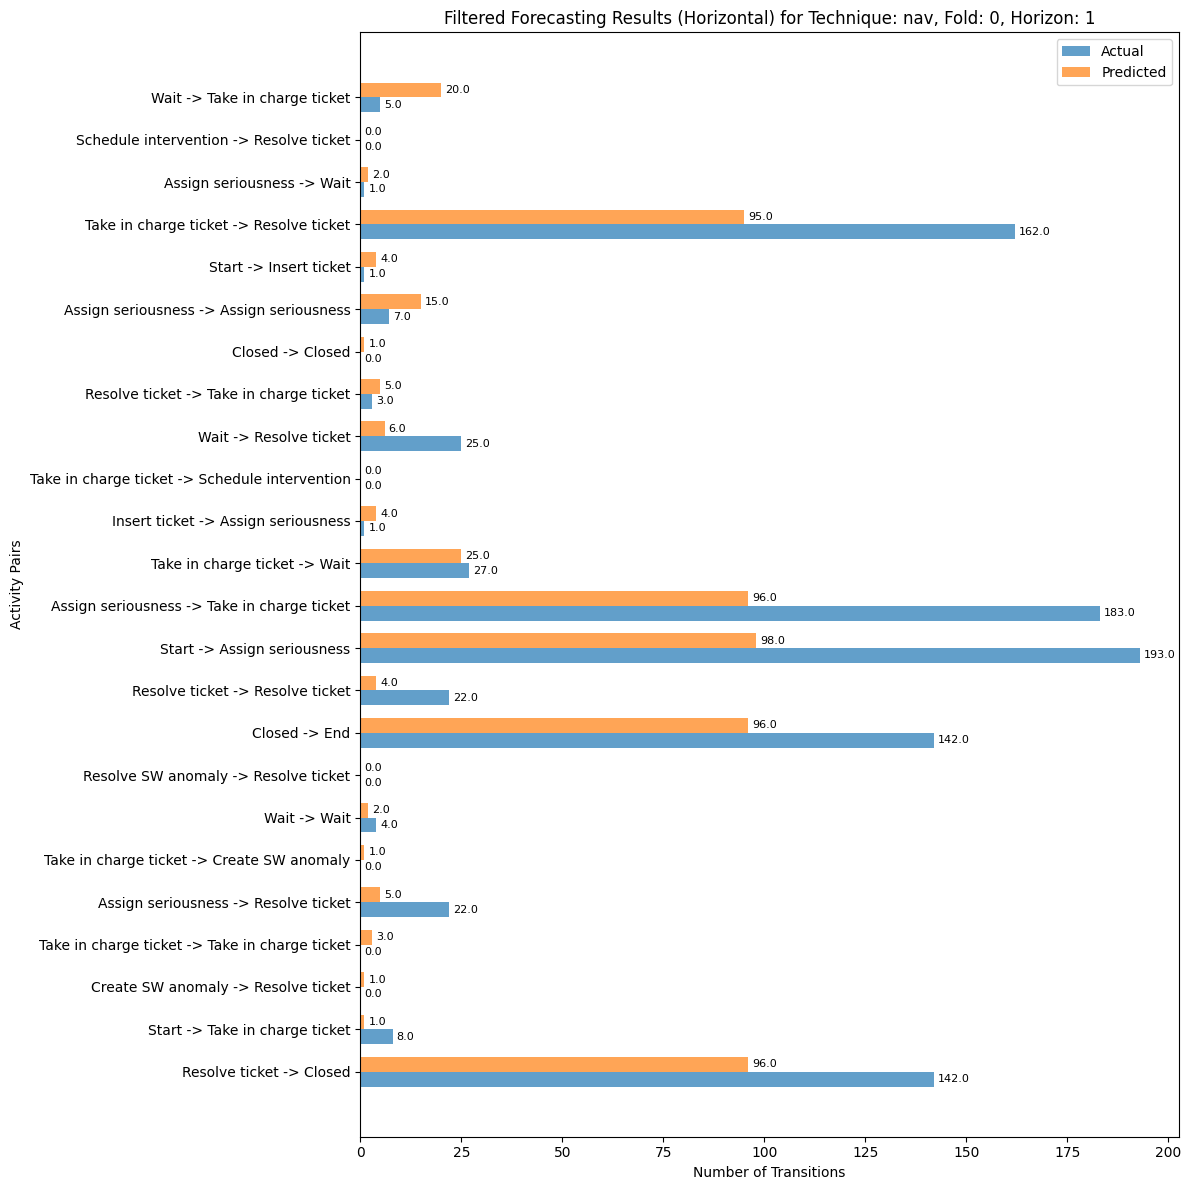

In [15]:
def visualize_filtered_forecasting_results_horizontal_with_labels_no_small_values(
    dfg_result_matrix, dfg_actual_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold=0.01):
    reverse_map = {v: k for k, v in act_map.items()}
    pred_values = []
    actual_values = []
    pair_labels = []

    for a, a2 in chosen_pairs:
        predicted = dfg_result_matrix[technique][a, a2, fold, horizon - 1]
        actual = dfg_actual_matrix[a, a2, fold, horizon - 1]

        if predicted > threshold or actual > threshold:
            pred_values.append(int(round(predicted)))
            actual_values.append(actual)
            pair_labels.append(f"{reverse_map[a]} -> {reverse_map[a2]}")

    if not pred_values or not actual_values:
        print("No transitions with values > threshold to visualize.")
        return

    y = np.arange(len(pair_labels))
    height = 0.35

    fig, ax = plt.subplots(figsize=(12, len(pair_labels) * 0.5))
    bars_actual = ax.barh(y - height / 2, actual_values, height, label='Actual', alpha=0.7)
    bars_predicted = ax.barh(y + height / 2, pred_values, height, label='Predicted', alpha=0.7)

    ax.set_ylabel('Activity Pairs')
    ax.set_xlabel('Number of Transitions')
    ax.set_title(f"Filtered Forecasting Results (Horizontal) for Technique: {technique}, Fold: {fold}, Horizon: {horizon}")
    ax.set_yticks(y)
    ax.set_yticklabels(pair_labels)
    ax.legend()

    for bar in bars_actual:
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.1f}', va='center', fontsize=8)

    for bar in bars_predicted:
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.1f}', va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

technique = 'nav'
fold = 0
horizon = 1
threshold = 0.1

visualize_filtered_forecasting_results_horizontal_with_labels_no_small_values(
    dfg_result_matrix, dfg_actual_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold)

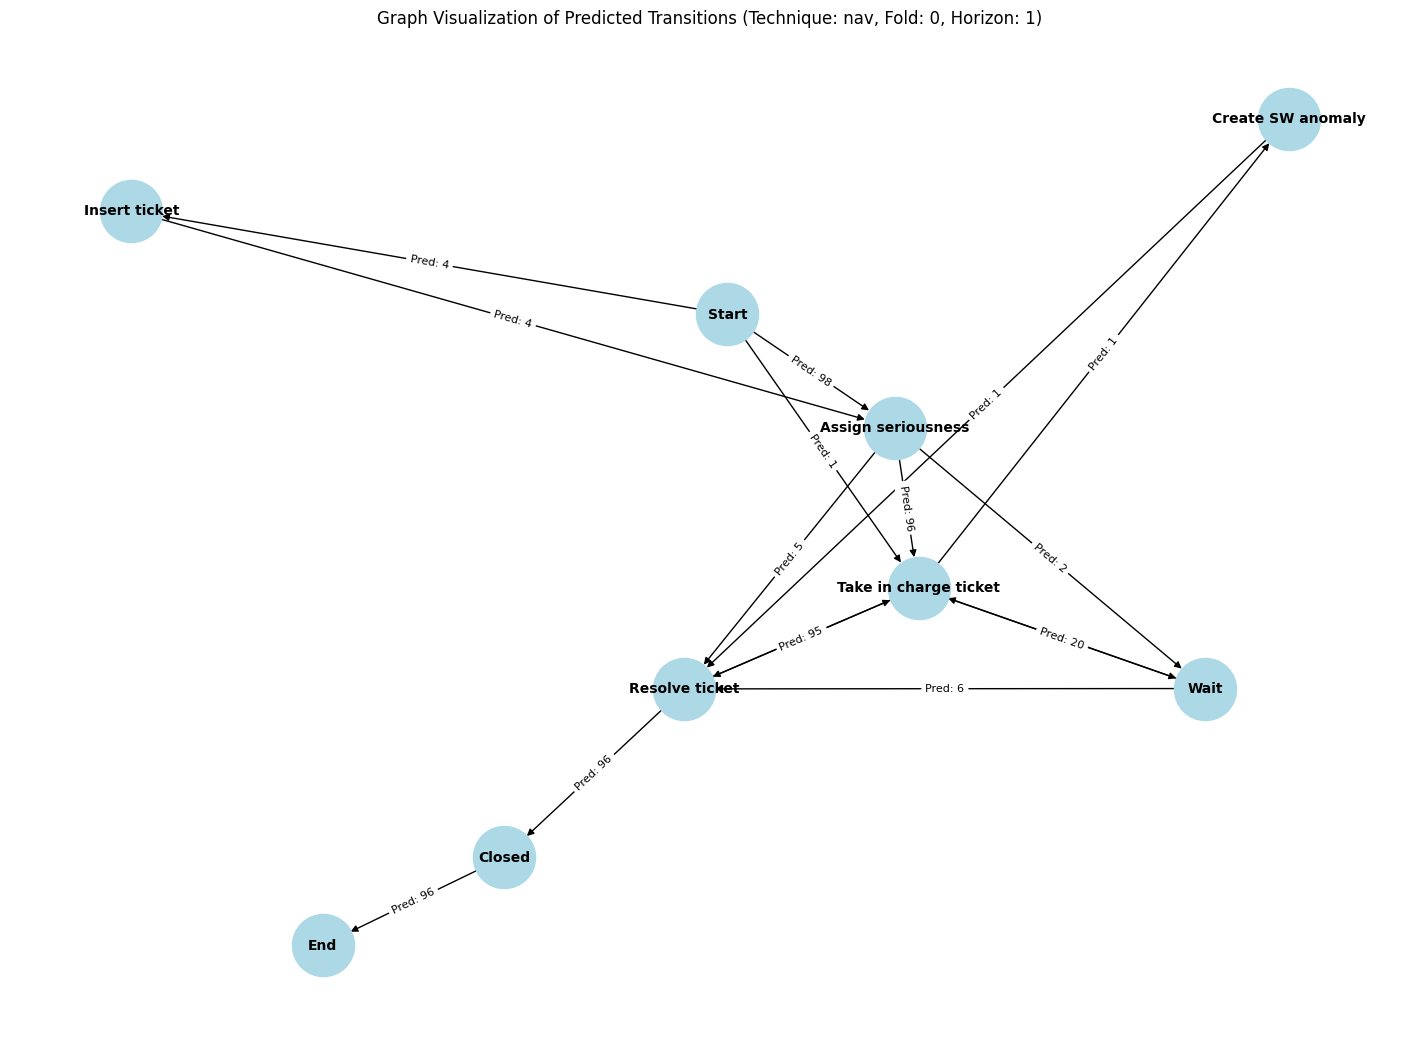

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_transitions_as_graph_only_predicted(dfg_result_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold=0.01):
    reverse_map = {v: k for k, v in act_map.items()}
    graph = nx.DiGraph()

    for a, a2 in chosen_pairs:
        predicted = dfg_result_matrix[technique][a, a2, fold, horizon - 1]

        if predicted > threshold:
            predicted = round(predicted)  # Округление до ближайшего целого
            if predicted > 0:  # Проверяем, чтобы после округления значение осталось положительным
                label = f"Pred: {predicted}"
                graph.add_edge(reverse_map[a], reverse_map[a2], weight=predicted, label=label)

    if not graph.edges:
        print("No transitions with values > threshold to visualize.")
        return

    # Позиционирование узлов графа с увеличенным расстоянием
    pos = nx.spring_layout(graph, k=2, seed=42)  # Увеличено значение k

    # Визуализация узлов и рёбер
    plt.figure(figsize=(14, 10))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    
    # Добавление подписей к рёбрам
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Graph Visualization of Predicted Transitions (Technique: {technique}, Fold: {fold}, Horizon: {horizon})")
    plt.tight_layout()
    plt.show()

# Пример вызова
technique = 'nav'
fold = 0
horizon = 1
threshold = 0.1

visualize_transitions_as_graph_only_predicted(
    dfg_result_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold
)


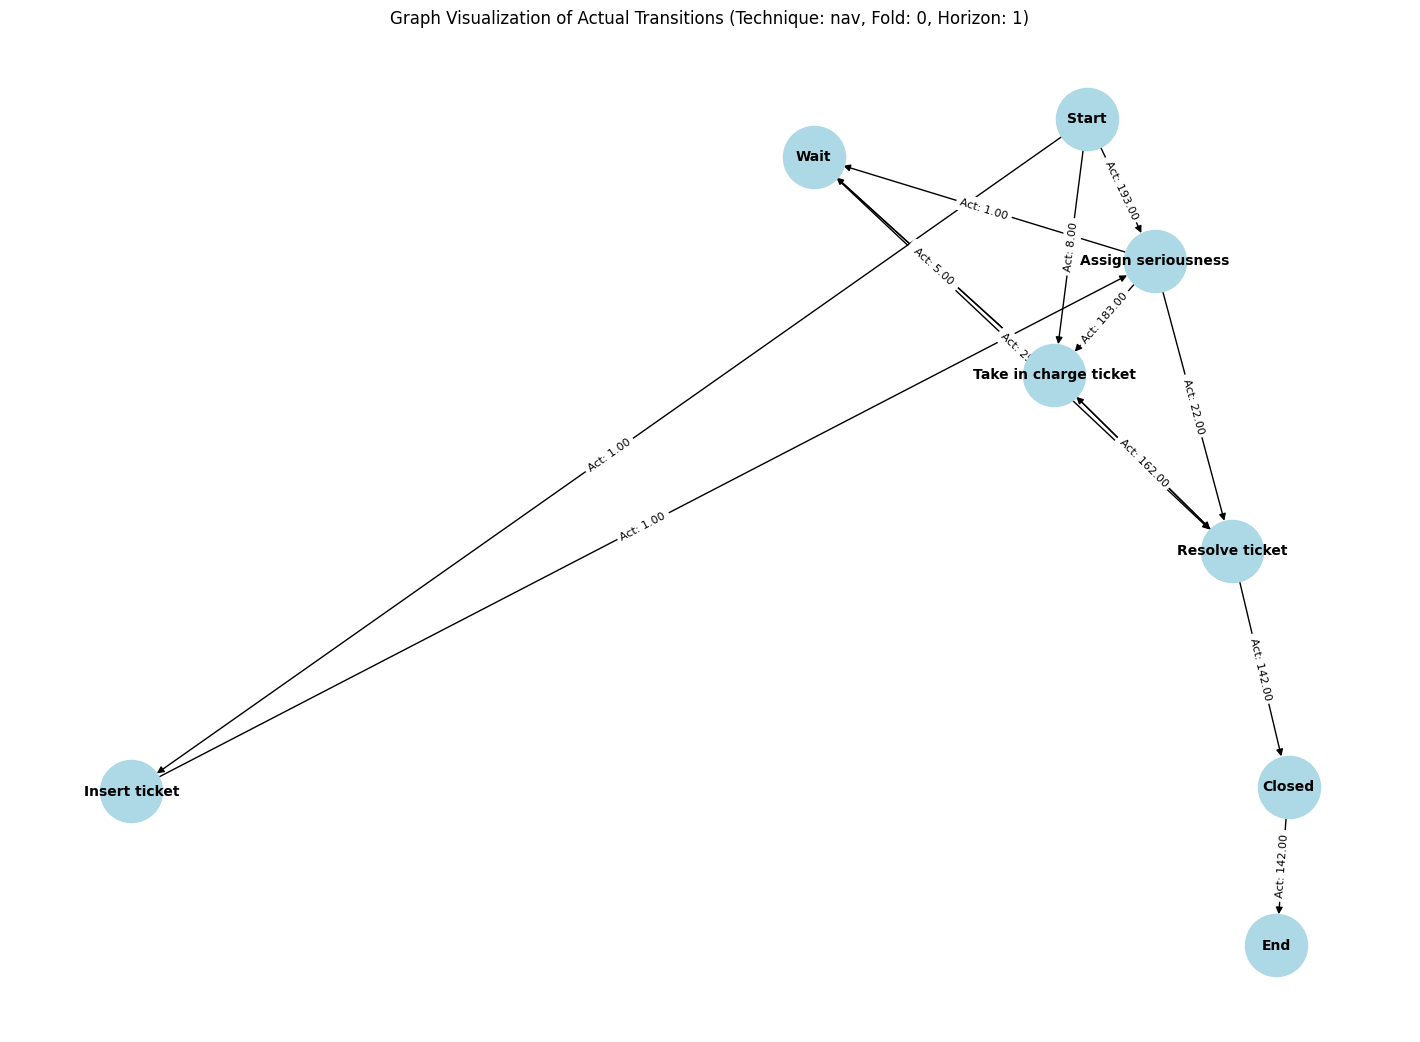

In [17]:
def visualize_transitions_as_graph_only_actuals(dfg_actual_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold=0.01):
    reverse_map = {v: k for k, v in act_map.items()}
    graph = nx.DiGraph()

    for a, a2 in chosen_pairs:
        actual = dfg_actual_matrix[a, a2, fold, horizon - 1]

        if actual > threshold:
            label = f"Act: {actual:.2f}"
            graph.add_edge(reverse_map[a], reverse_map[a2], weight=actual, label=label)

    if not graph.edges:
        print("No transitions with values > threshold to visualize.")
        return
    pos = nx.spring_layout(graph, k=2, seed=42)

    # Визуализация узлов и рёбер
    plt.figure(figsize=(14, 10))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    
    # Добавление подписей к рёбрам
    edge_labels = nx.get_edge_attributes(graph, 'label')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Graph Visualization of Actual Transitions (Technique: {technique}, Fold: {fold}, Horizon: {horizon})")
    plt.tight_layout()
    plt.show()

# Пример вызова
technique = 'nav'
fold = 0
horizon = 1
threshold = 0.1

visualize_transitions_as_graph_only_actuals(
    dfg_actual_matrix, act_map, chosen_pairs, technique, fold, horizon, threshold
)


Прогнозирование для пары активностей:  Start -> Assign seriousness
Прогнозирование для пары активностей:  Start -> Take in charge ticket
Прогнозирование для пары активностей:  Start -> Resolve ticket
Прогнозирование для пары активностей:  Start -> Insert ticket
Прогнозирование для пары активностей:  Start -> Wait
Прогнозирование для пары активностей:  Start -> Create SW anomaly
Прогнозирование для пары активностей:  Assign seriousness -> Assign seriousness
Прогнозирование для пары активностей:  Assign seriousness -> Take in charge ticket
Прогнозирование для пары активностей:  Assign seriousness -> Resolve ticket
Прогнозирование для пары активностей:  Assign seriousness -> Wait
Прогнозирование для пары активностей:  Assign seriousness -> Create SW anomaly
Прогнозирование для пары активностей:  Assign seriousness -> Require upgrade
Прогнозирование для пары активностей:  Take in charge ticket -> Assign seriousness
Прогнозирование для пары активностей:  Take in charge ticket -> Take in cha

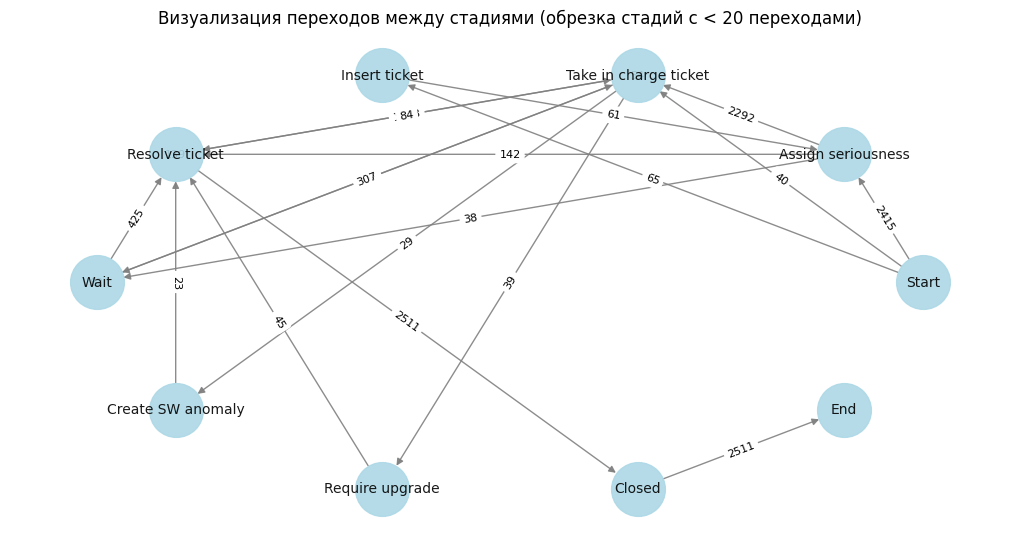

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from datetime import datetime

# Предположим, что переменные forecast_results, techniques, act_map, chosen_pairs, dfg_time_matrix, reverse_map уже определены

forecast_results = {}
model_name = 'nav'
forecast_model = techniques[model_name]
february_start = datetime(2014, 2, 1)
february_end = datetime(2014, 2, 28)

for act, a in act_map.items():
    for act_2, a2 in act_map.items():
        if (a, a2) in chosen_pairs:
            print(f'Прогнозирование для пары активностей:  {act} -> {act_2}')
            time_series = dfg_time_matrix[:, a, a2]
            try:
                prediction = forecast_model.fit(time_series, horizon=(february_end - february_start).days)
                forecast_results[(a, a2)] = prediction
            except Exception as e:
                print('Ошибка при прогнозировании')
                forecast_results[(a, a2)] = np.zeros((february_end - february_start).days)

transition_graph = nx.DiGraph()

for (act1, act2), preds in forecast_results.items():
    total_transitions = int(np.sum(preds))
    if total_transitions >= 20:  # Проверка на минимальное количество переходов
        transition_graph.add_edge(reverse_map[act1], reverse_map[act2], weight=total_transitions)

plt.figure(figsize=(10, 5))
pos = nx.circular_layout(transition_graph)
nx.draw(transition_graph, pos, with_labels=True, node_size=1500, font_size=10, node_color='lightblue', edge_color='gray', alpha=0.9)
edge_labels = nx.get_edge_attributes(transition_graph, 'weight')
nx.draw_networkx_edge_labels(transition_graph, pos, edge_labels=edge_labels, font_size=8)
plt.title('Визуализация переходов между стадиями (обрезка стадий с < 20 переходами)')
plt.show()